On this notebook:

Examine instances of encoder representations and compare to ground-truth reps that originally came from the generator.

First:

Setup matplotlib, torch, and numpy for a high-resolution browser.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 0.25
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.linewidth'] = 0.25

load alexnet pretrained on places

In [2]:
import torchvision
import torch.hub

model = torchvision.models.alexnet(num_classes=365)
url = 'http://gandissect.csail.mit.edu/models/alexnet_places365-6d3c0e75.pth'
sd = torch.hub.load_state_dict_from_url(url)['state_dict']
sd = {k.replace('.module', ''): v for k, v in sd.items()}
model.load_state_dict(sd)

from netdissect import nethook
model = nethook.InstrumentedModel(model)
model = model.cuda()

In [3]:
# Load labels
from urllib.request import urlopen

synset_url = 'http://gandissect.csail.mit.edu/models/categories_places365.txt'
labels = [r.split(' ')[0][3:] for r in urlopen(synset_url).read().decode('utf-8').split('\n')]

load segmenter

In [4]:
from netdissect import segmenter
segmodel = segmenter.UnifiedParsingSegmenter(segsizes=[256])

load places dataset

In [5]:
from importlib import reload
from netdissect import parallelfolder
from torchvision import transforms

reload(parallelfolder)

centre_crop = transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

dataset = parallelfolder.ParallelImageFolders(
    ['dataset/places/val'], transform=[centre_crop],
    shuffle=True)

Test classifier on some images

In [8]:
from netdissect import renormalize

indices = range(200,204)
batch = torch.cat([dataset[i][0][None,...] for i in indices])
preds = model(batch.cuda()).max(1)[1]
imgs = [renormalize.as_image(t, source=dataset) for t in batch]
prednames = [labels[p.item()] for p in preds]



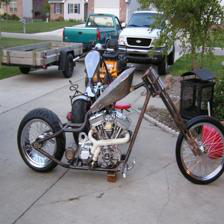
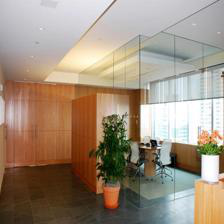
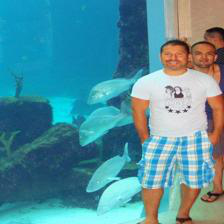
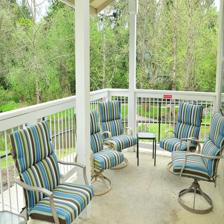

In [9]:
from netdissect import show
reload(show)
show.blocks(zip(imgs, prednames))

create adapter to segmenter

In [10]:
from netdissect import renormalize
reload(renormalize)
renorm = renormalize.renormalizer(dataset, mode='zc')

segment single image, and visualize the labels

,
,ground
,bicycle
,car
,tree
,building
,grass
,sidewalk
,person
,motorbike
,ashcan

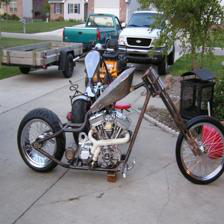
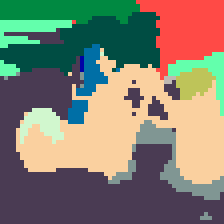
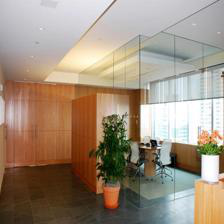
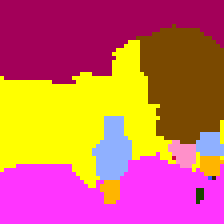
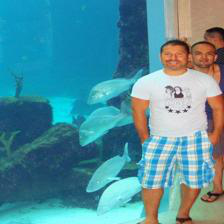
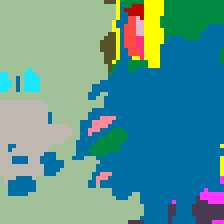
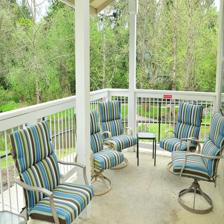
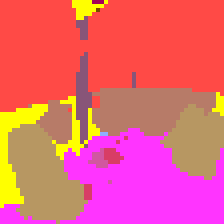

In [11]:
seg = segmodel.segment_batch(renorm(batch).cuda(), downsample=4)
import netdissect.segviz
reload(netdissect.segviz)
from netdissect.segviz import seg_as_image, segment_key
show.rows([(imgs[i], seg_as_image(seg[i,0], size=imgs[i].size),
            show.rows(segment_key(seg[i,0], segmodel, 10)))
            for i in range(len(seg))])

visualize activations for single layer of single image

In [12]:
# model.stop_retaining_layers([('features.8', 'conv5')])
model.retain_layer(('features.10', 'conv5'))
batch = torch.cat([dataset[i][0][None,...] for i in indices])
preds = model(batch.cuda()).max(1)[1]
imgs = [renormalize.as_image(t, source=dataset) for t in batch]
prednames = [labels[p.item()] for p in preds]


from matplotlib import cm
cm.hot([[0.1, 0.3, 0.4], [0.1, 0.3, 0.4]]).shape

(2, 3, 4)


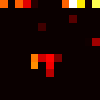
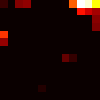
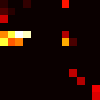
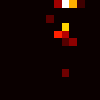
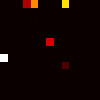
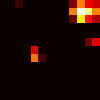
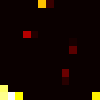
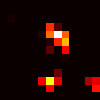
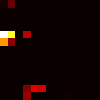
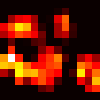
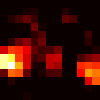
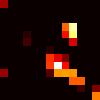
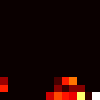
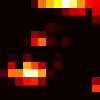
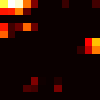
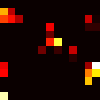
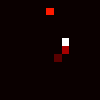
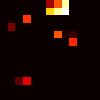
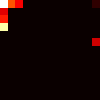
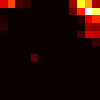
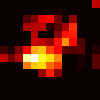
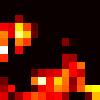
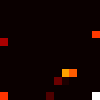
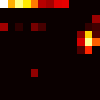
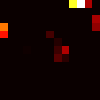
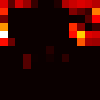
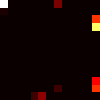
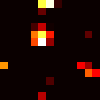
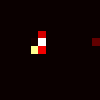
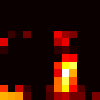
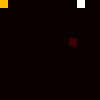
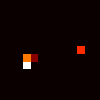
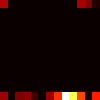
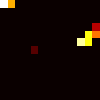
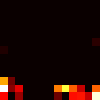
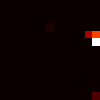
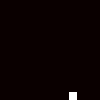
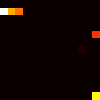
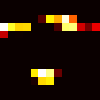
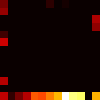
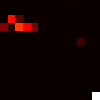
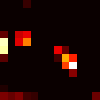
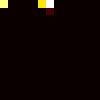
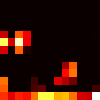
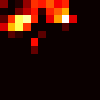
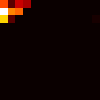
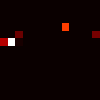
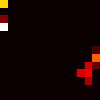
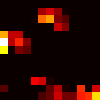
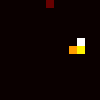
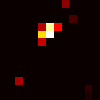
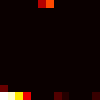
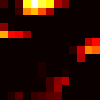
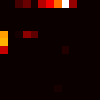
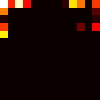
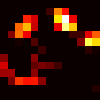
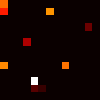
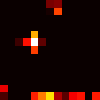
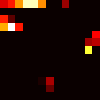
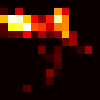
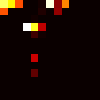
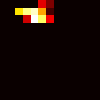
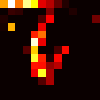
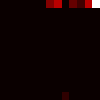
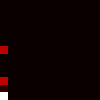
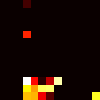
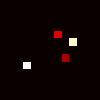
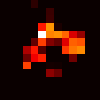
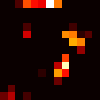
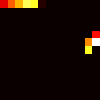
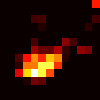
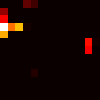
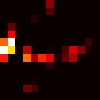
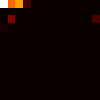
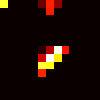
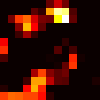
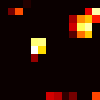
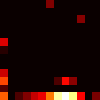
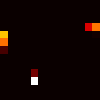
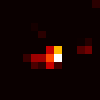
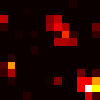
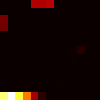
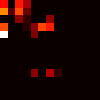
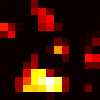
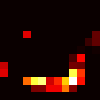
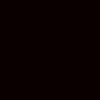
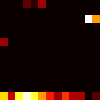
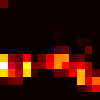
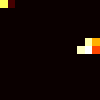
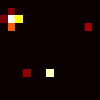
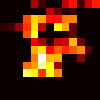
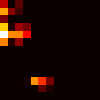
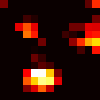
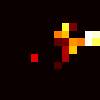
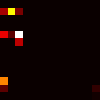
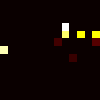
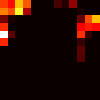
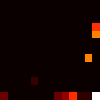
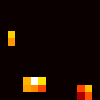
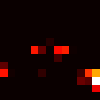
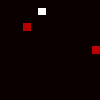
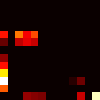
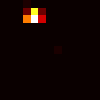
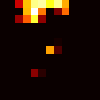
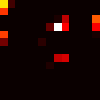
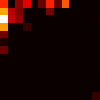
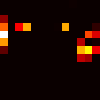
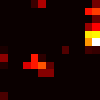
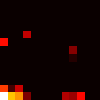
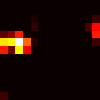
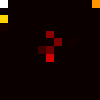
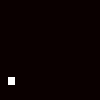
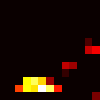
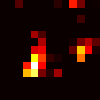
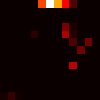
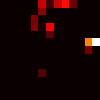
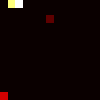
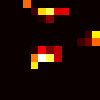
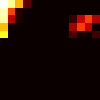
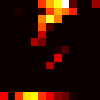
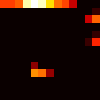
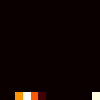
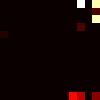
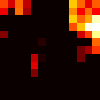
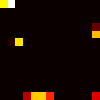
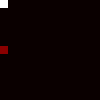
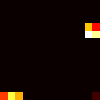
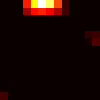
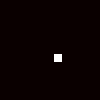
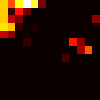
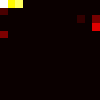
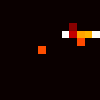
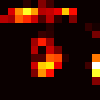
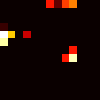
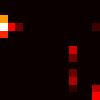
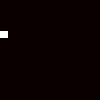
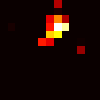
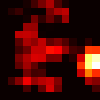
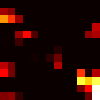
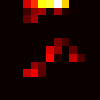
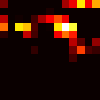
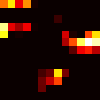
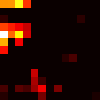
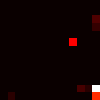
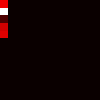
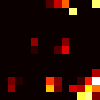
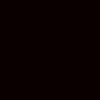
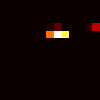
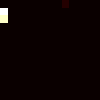
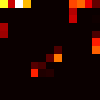
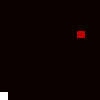
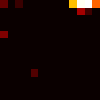
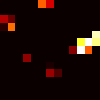
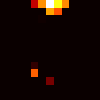
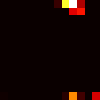
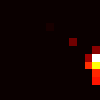
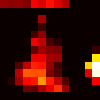
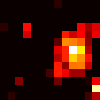
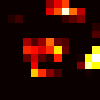
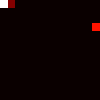
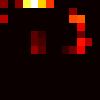
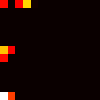
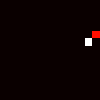
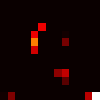
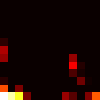
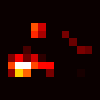
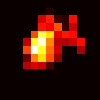
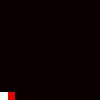
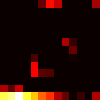
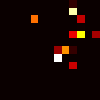
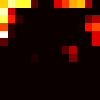
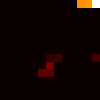
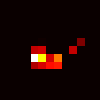
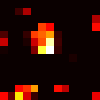
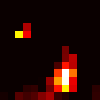
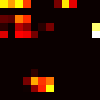
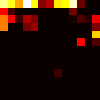
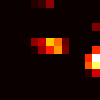
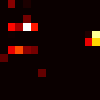
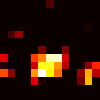
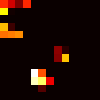
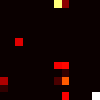
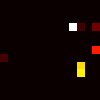
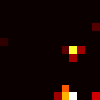
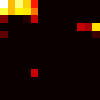
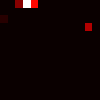
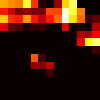
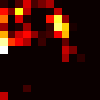
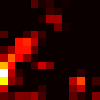
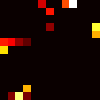
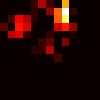
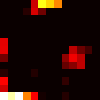
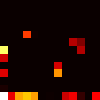
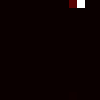
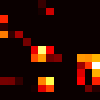
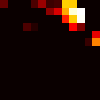
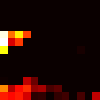
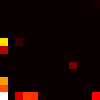
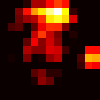
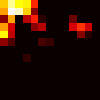
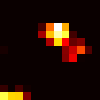
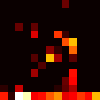
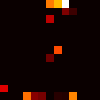
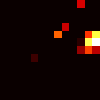
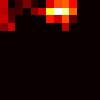
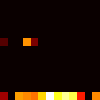
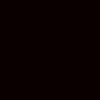
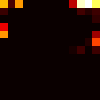
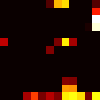
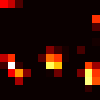
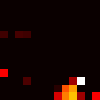
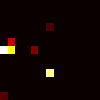
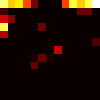
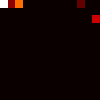
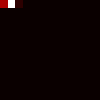
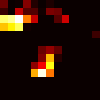
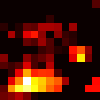
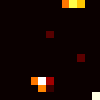
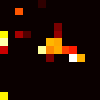
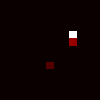
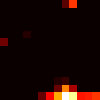
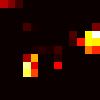
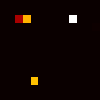
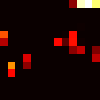
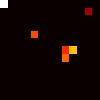
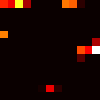
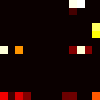
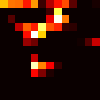
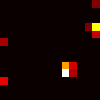
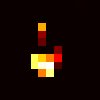
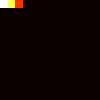
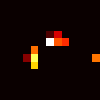
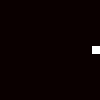
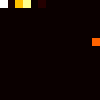
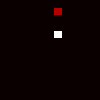
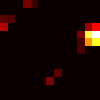
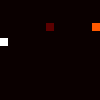
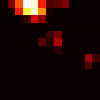
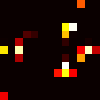
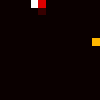
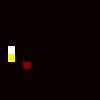
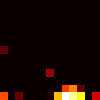
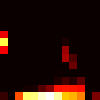
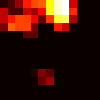
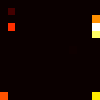
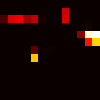
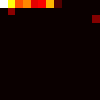
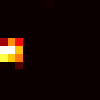
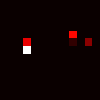
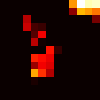
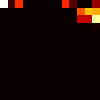
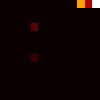
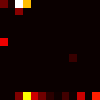
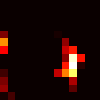
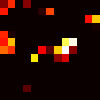
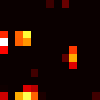

In [13]:
import PIL
acts = model.retained_layer('conv5').cpu()
show.blocks(
    [PIL.Image.fromarray((cm.hot(a/(1e-10 +a.max())) * 255).astype('uint8')).resize((100, 100), PIL.Image.NEAREST)]
    for a in acts[0])

/afs/csail.mit.edu/u/d/davidbau/.conda/envs/p3t11/lib/python3.6/site-packages/torch/nn/functional.py:2457: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/afs/csail.mit.edu/u/d/davidbau/.conda/envs/p3t11/lib/python3.6/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))



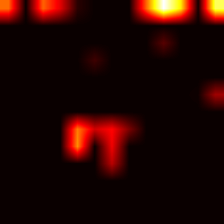
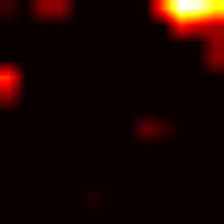
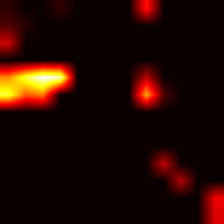
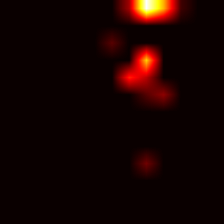
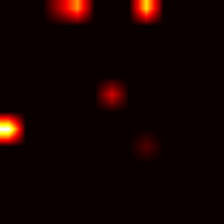
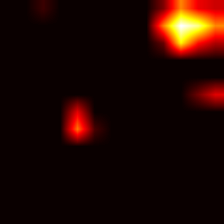
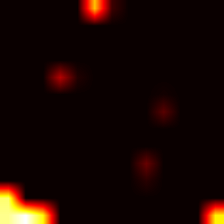
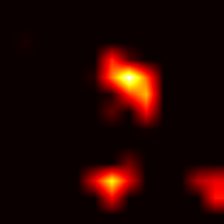
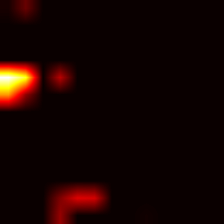
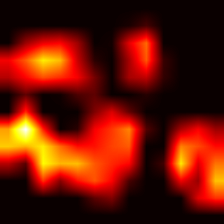
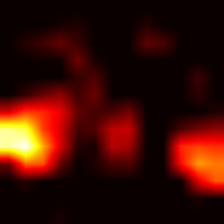
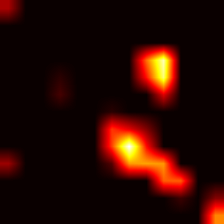
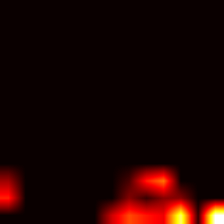
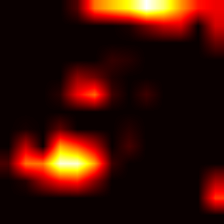
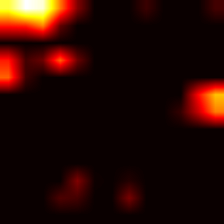
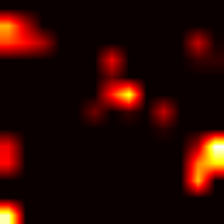
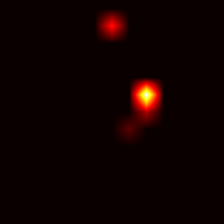
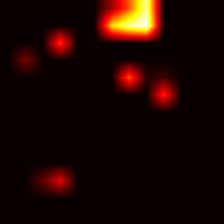
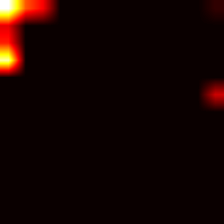
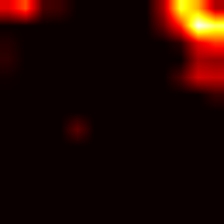
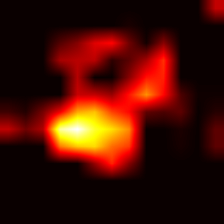
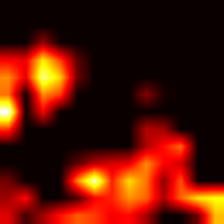
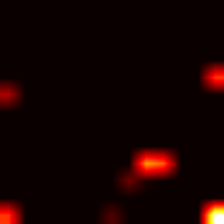
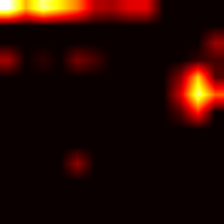
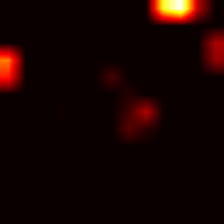
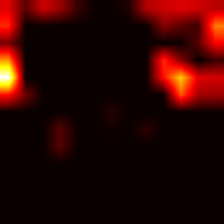
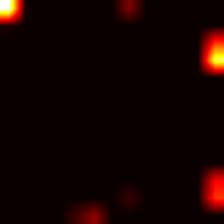
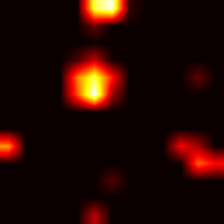
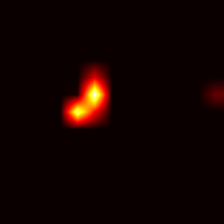
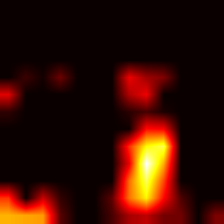
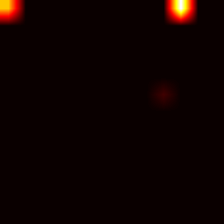
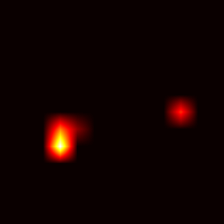
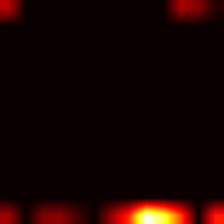
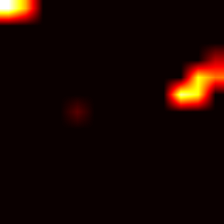
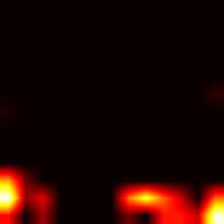
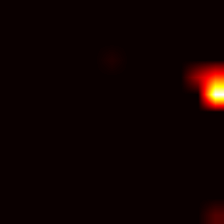
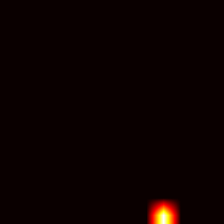
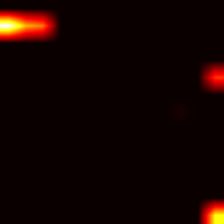
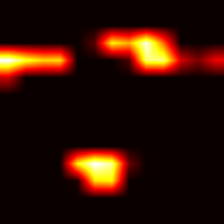
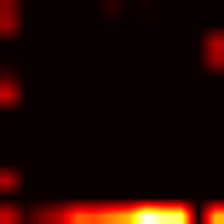
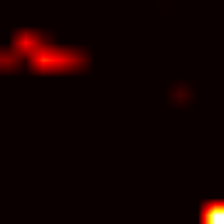
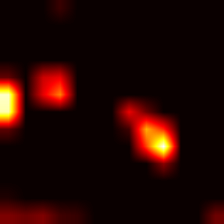
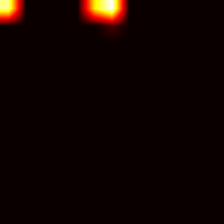
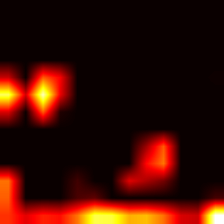
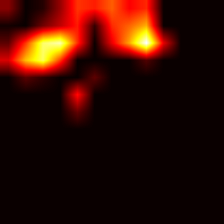
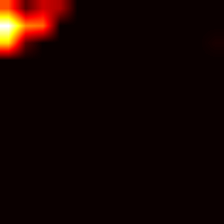
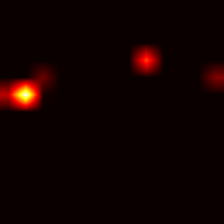
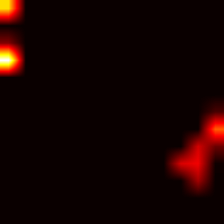
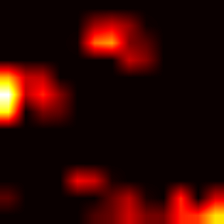
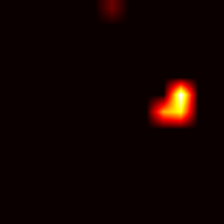
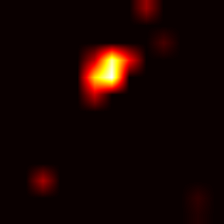
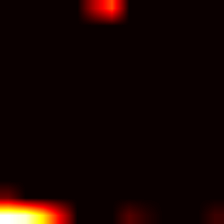
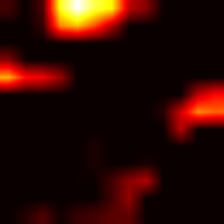
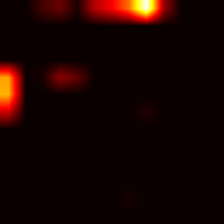
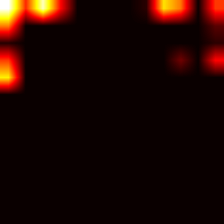
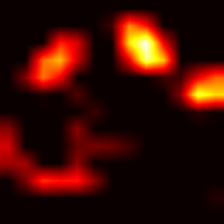
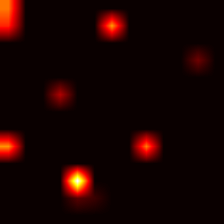
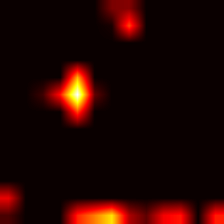
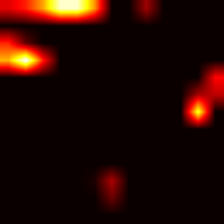
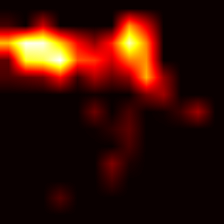
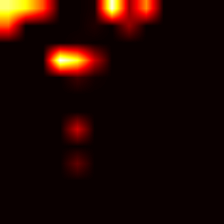
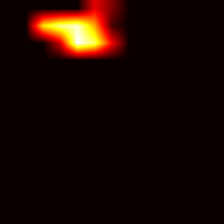
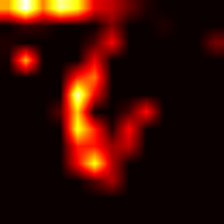
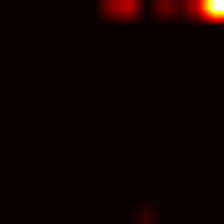
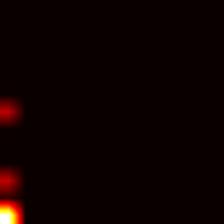
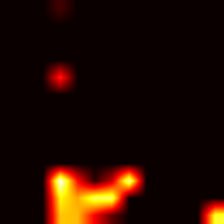
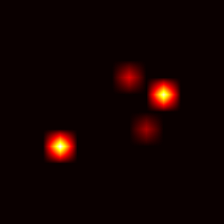
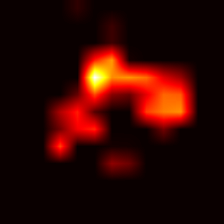
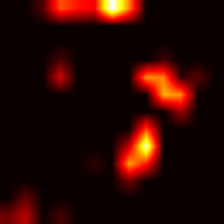
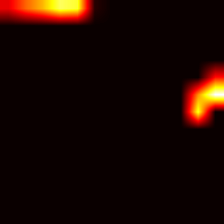
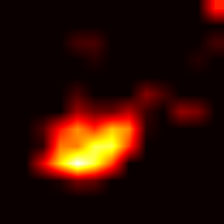
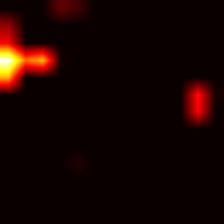
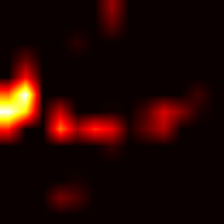
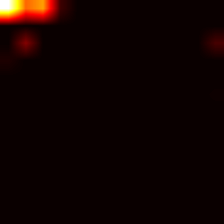
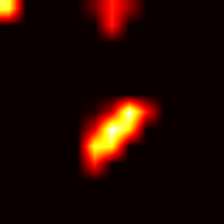
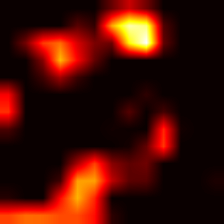
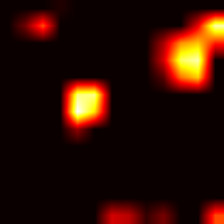
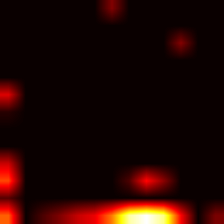
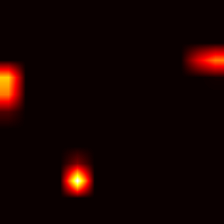
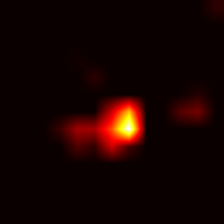
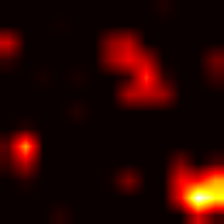
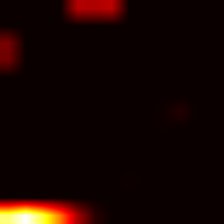
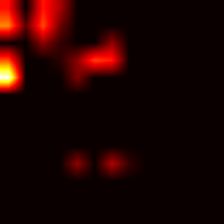
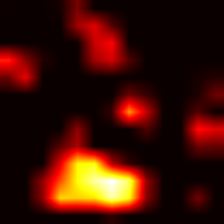
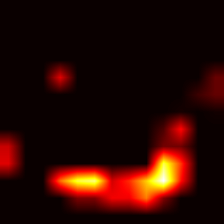
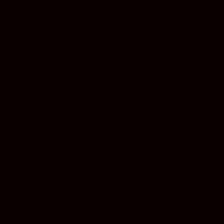
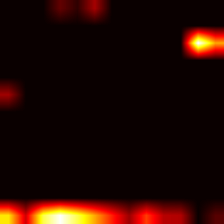
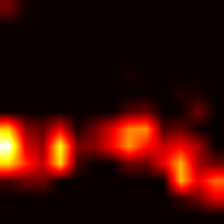
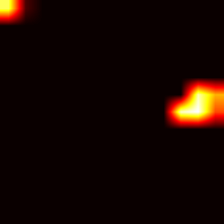
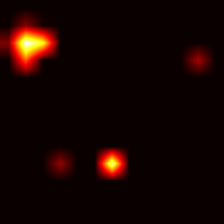
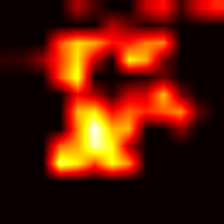
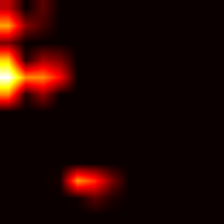
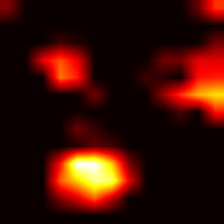
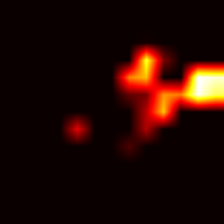
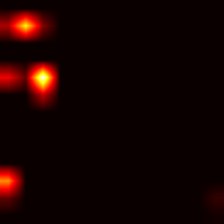
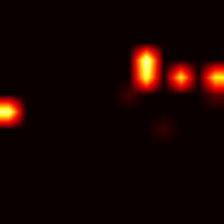
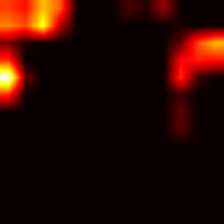
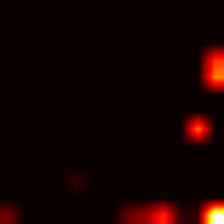
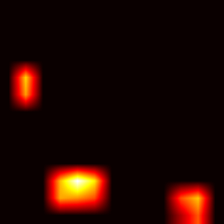
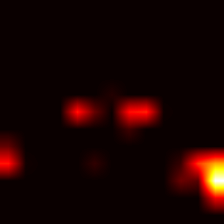
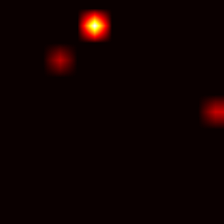
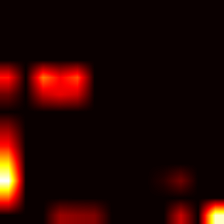
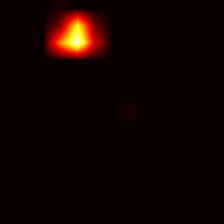
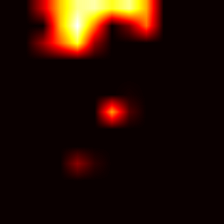
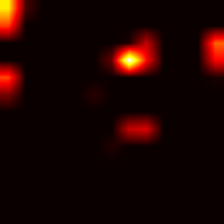
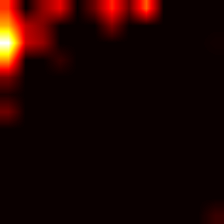
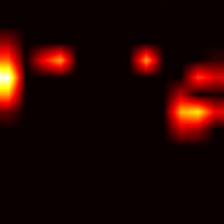
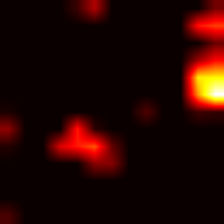
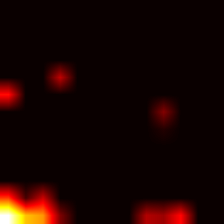
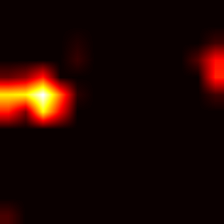
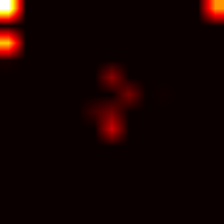
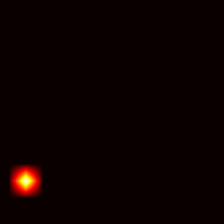
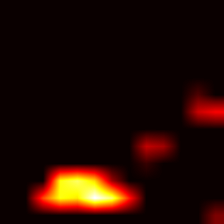
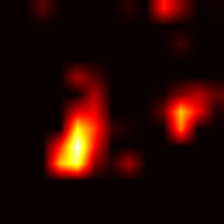
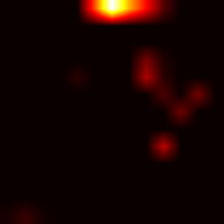
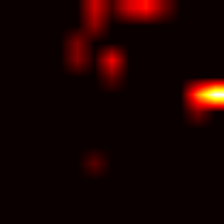
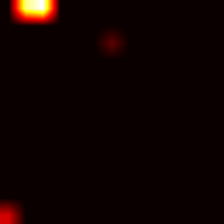
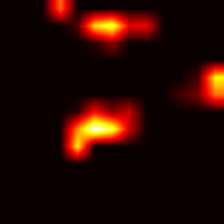
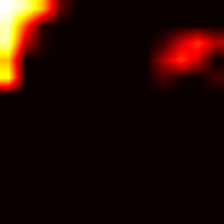
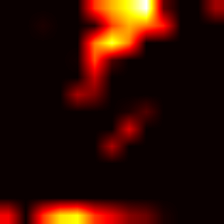
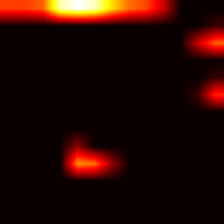
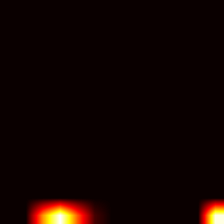
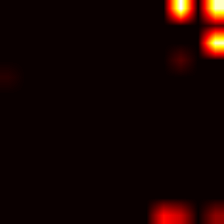
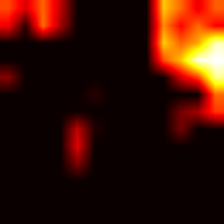
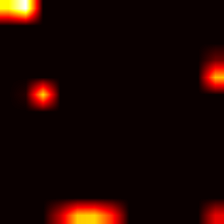
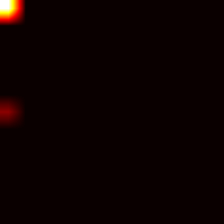
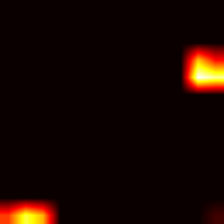
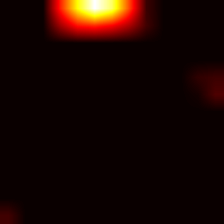
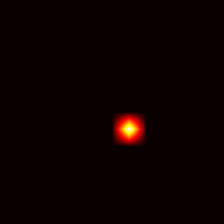
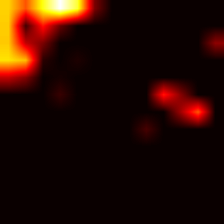
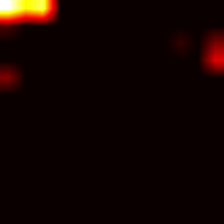
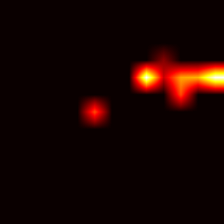
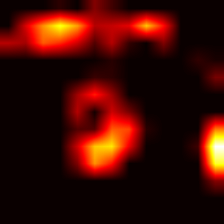
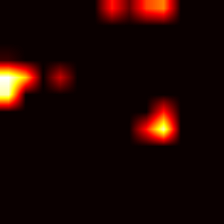
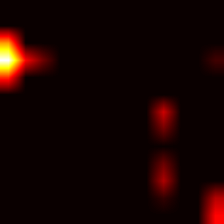
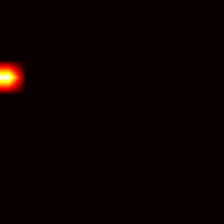
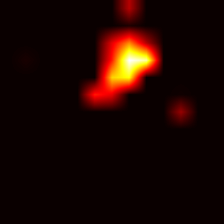
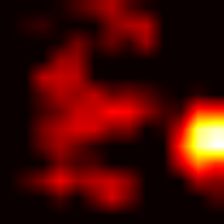
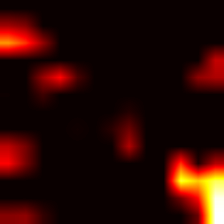
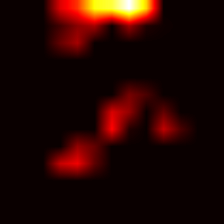
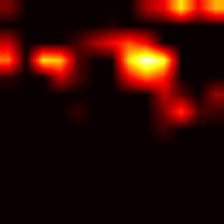
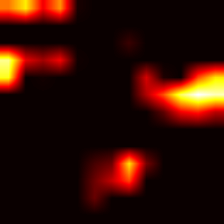
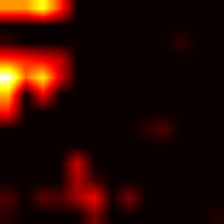
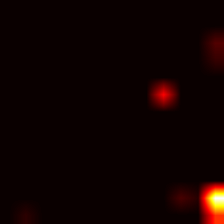
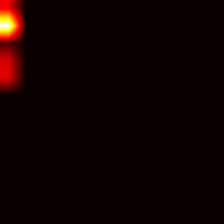
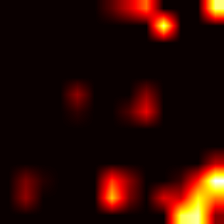
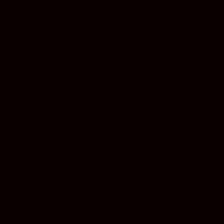
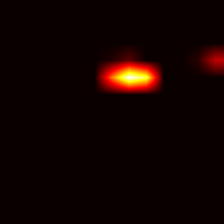
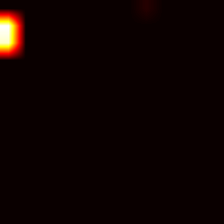
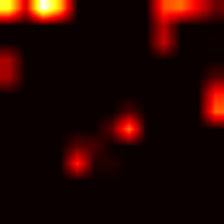
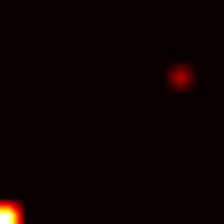
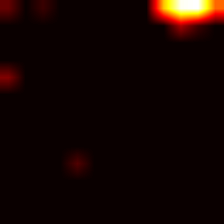
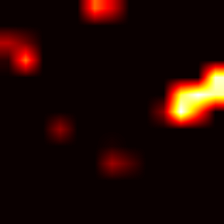
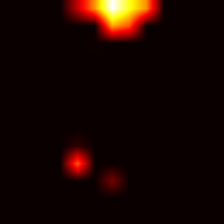
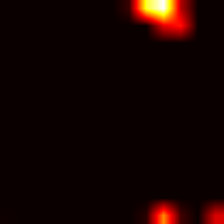
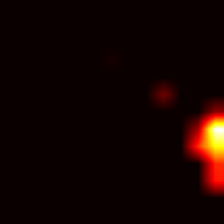
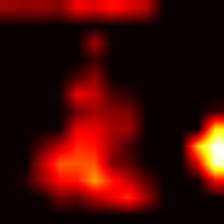
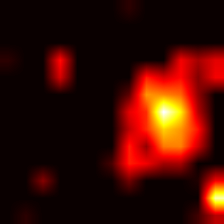
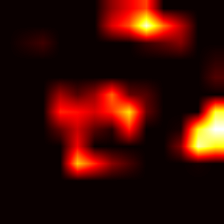
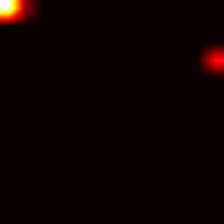
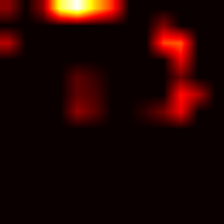
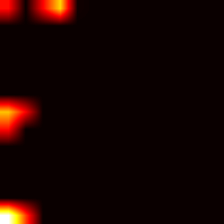
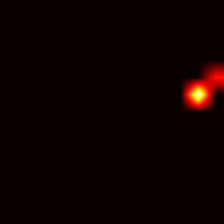
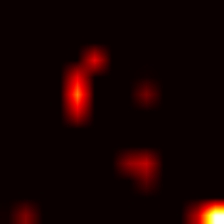
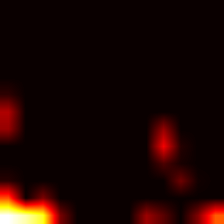
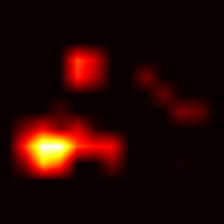
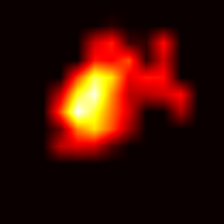
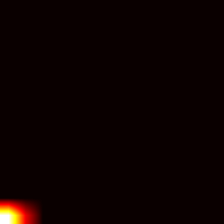
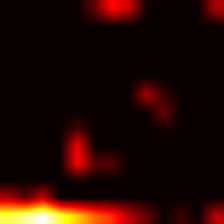
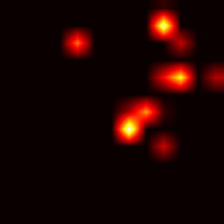
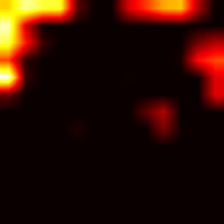
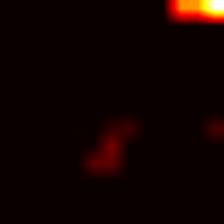
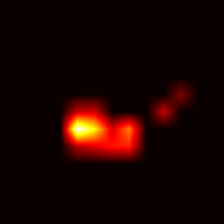
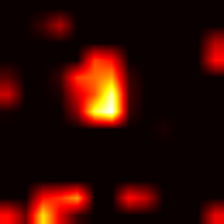
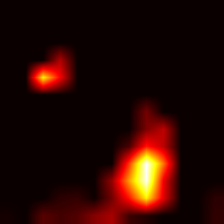
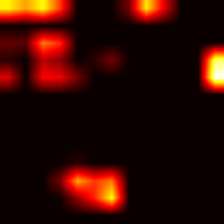
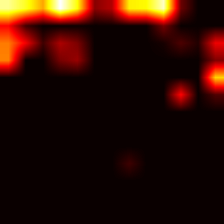
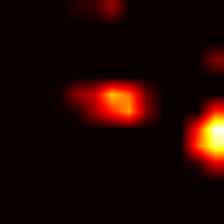
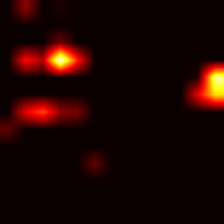
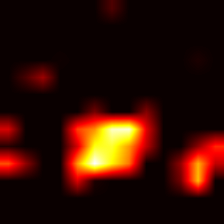
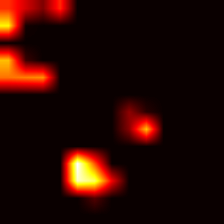
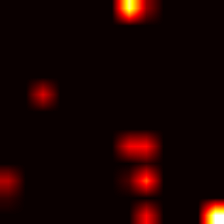
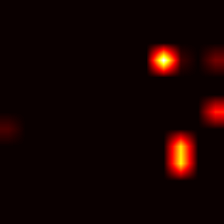
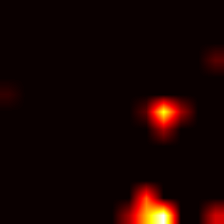
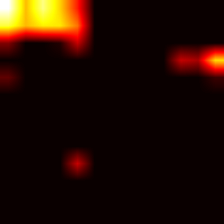
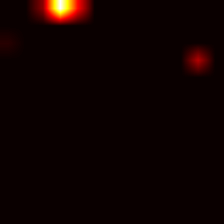
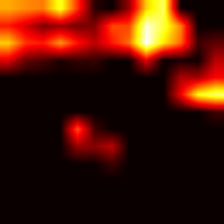
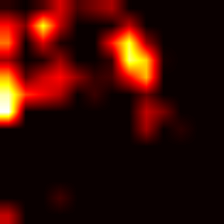
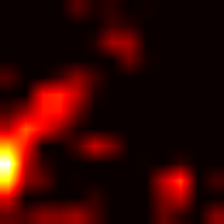
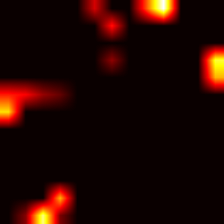
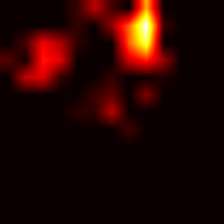
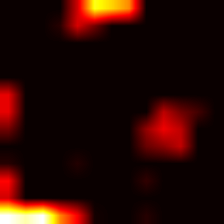
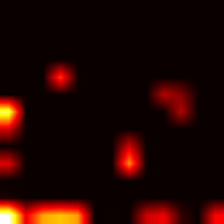
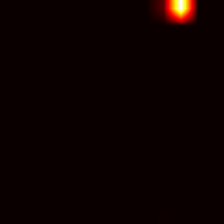
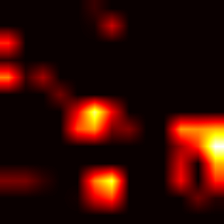
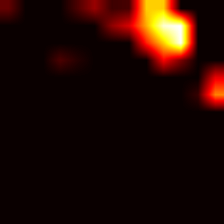
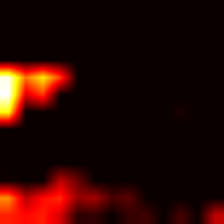
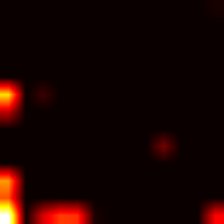
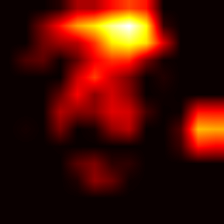
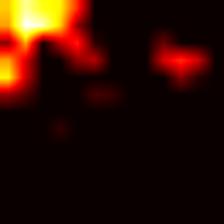
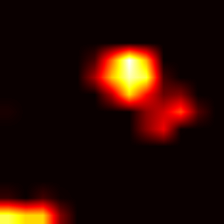
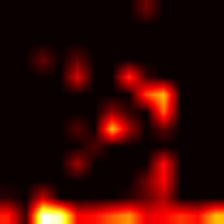
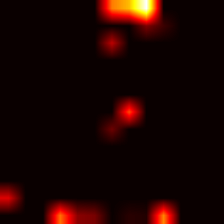
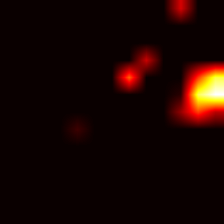
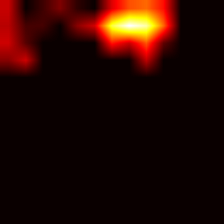
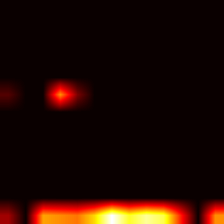
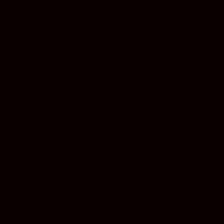
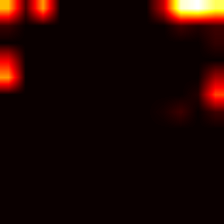
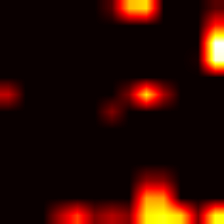
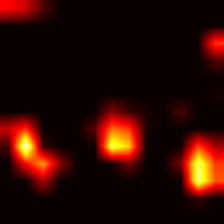
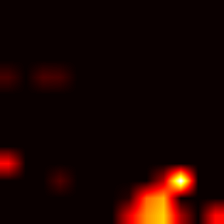
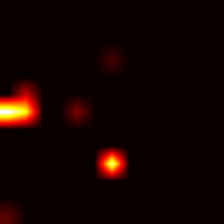
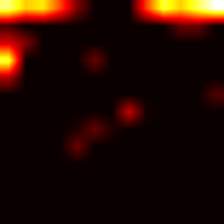
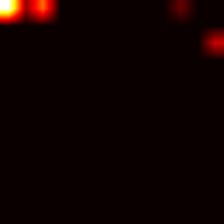
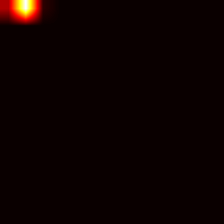
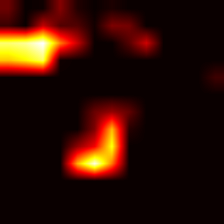
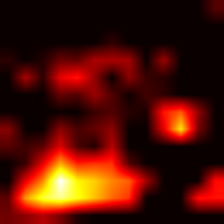
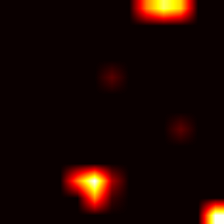
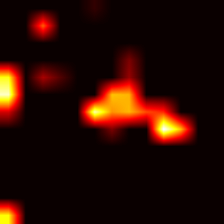
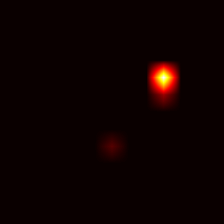
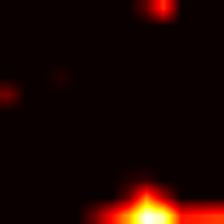
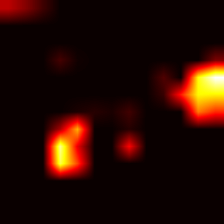
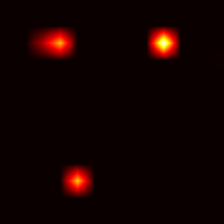
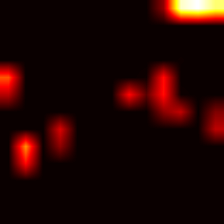
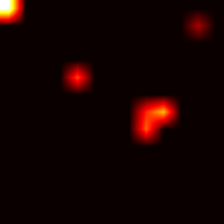
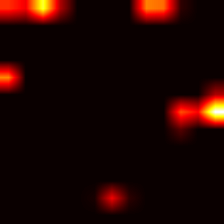
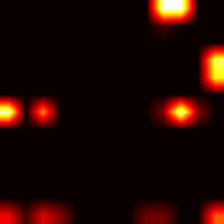
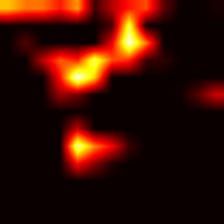
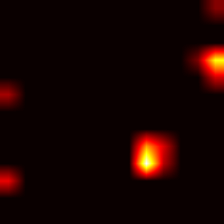
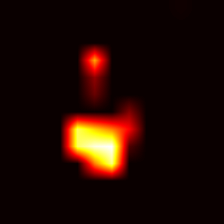
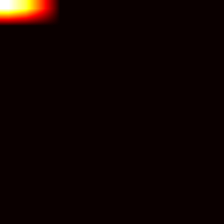
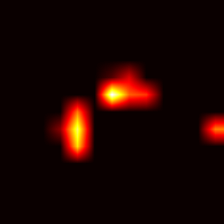
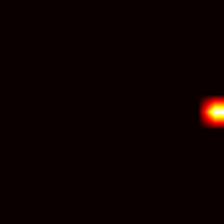
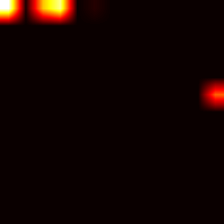
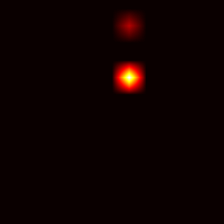
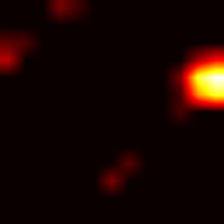
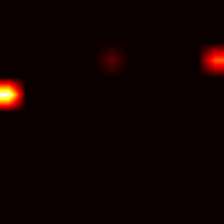
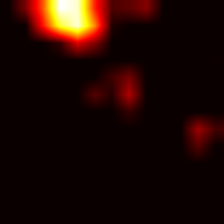
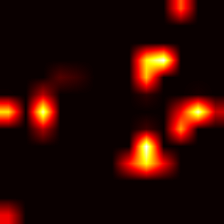
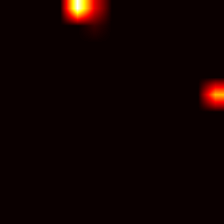
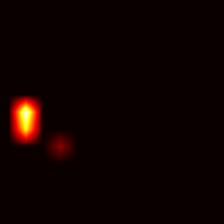
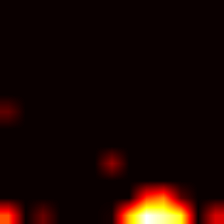
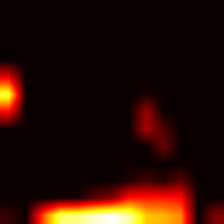
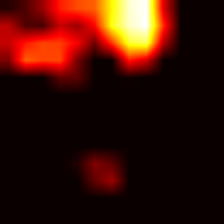
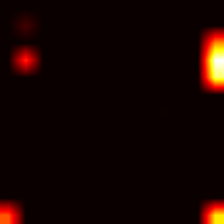
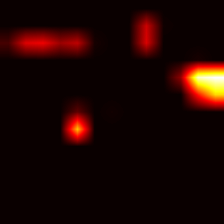
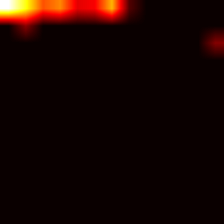
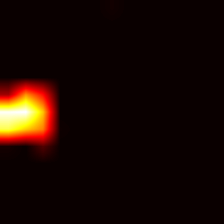
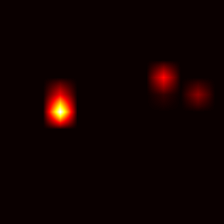
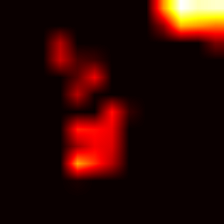
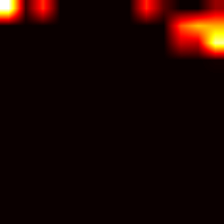
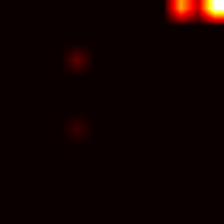
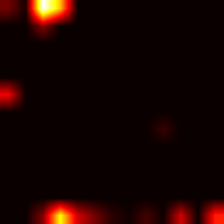
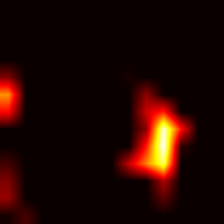
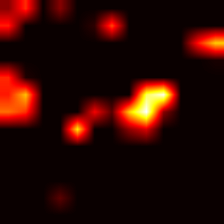
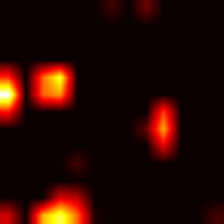

In [14]:
import torch
hacts = torch.nn.functional.upsample(acts, size=batch.shape[2:], mode='bilinear')
show.blocks(
    [PIL.Image.fromarray((cm.hot(a/(1e-10 +a.max())) * 255).astype('uint8'))]
    for a in hacts[0])

In [61]:
from netdissect import tally
reload(tally)

def compute_samples(batch):
    image_batch = batch[0].cuda()
    _ = model(image_batch)
    acts = model.retained_layer('conv5')
    hacts = torch.nn.functional.interpolate(acts, size=56,
                                        mode='bilinear', align_corners=False)
    return hacts.permute(0, 2, 3, 1).contiguous().view(-1, acts.shape[1])
    
def compute_conditional_samples(batch):
    image_batch = batch[0].cuda()
    _ = model(image_batch)
    acts = model.retained_layer('conv5')
    seg = segmodel.segment_batch(renorm(image_batch), downsample=4)
    hacts = torch.nn.functional.interpolate(acts, size=seg.shape[2:],
                                            mode='bilinear', align_corners=False)
    return tally.conditional_samples(hacts, seg)

# TODO: maybe a graph to visualize the results on a small batch like this.
out = compute_conditional_samples([batch.cuda()])
for index, stats in out:
    print(index, stats.shape)


0 torch.Size([12544, 256])
1 torch.Size([1150, 256])
2 torch.Size([32, 256])
3 torch.Size([1456, 256])
4 torch.Size([1557, 256])
5 torch.Size([365, 256])
6 torch.Size([1367, 256])
7 torch.Size([804, 256])
9 torch.Size([500, 256])
10 torch.Size([4, 256])
11 torch.Size([150, 256])
12 torch.Size([516, 256])
13 torch.Size([347, 256])
14 torch.Size([151, 256])
17 torch.Size([143, 256])
19 torch.Size([7, 256])
21 torch.Size([1, 256])
22 torch.Size([1090, 256])
23 torch.Size([9, 256])
25 torch.Size([13, 256])
29 torch.Size([35, 256])
35 torch.Size([1094, 256])
40 torch.Size([1, 256])
41 torch.Size([50, 256])
44 torch.Size([1, 256])
45 torch.Size([245, 256])
53 torch.Size([341, 256])
56 torch.Size([78, 256])
57 torch.Size([819, 256])
58 torch.Size([24, 256])
59 torch.Size([16, 256])
60 torch.Size([55, 256])
72 torch.Size([30, 256])
106 torch.Size([59, 256])
183 torch.Size([9, 256])
255 torch.Size([25, 256])
336 torch.Size([25, 256])
337 torch.Size([14, 256])
338 torch.Size([512, 256])
339 torc

In [27]:
from netdissect import tally
reload(tally)
result = tally.tally_conditional_quantile(compute_conditional_samples,
        dataset, sample_size=1000)


In [62]:
from netdissect import tally
reload(tally)
rq = tally.tally_quantile(compute_samples, dataset, sample_size=1000)


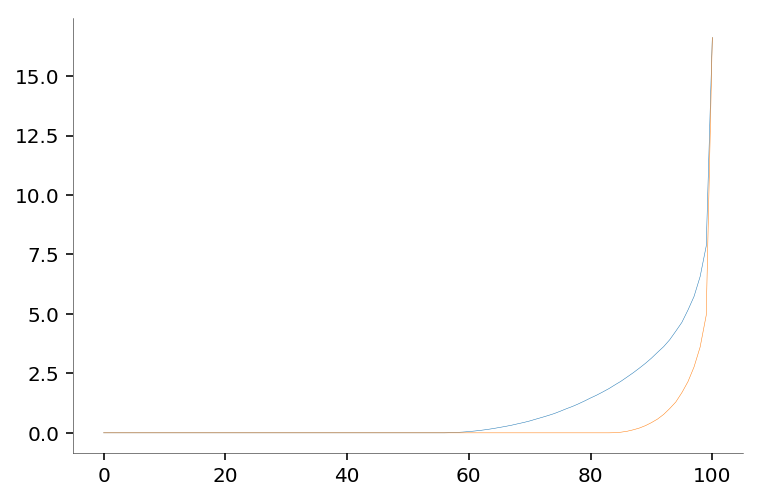

In [92]:
amt, ind = ((result.conditional(1).readout(1000) -
  result.conditional(0).readout(1000)).abs().sum(1)/1000).max(0)
fig, ax = plt.subplots()
def dens(cum):
    return cum[1:] - cum[:-1]
ax.plot(result.conditional(1).readout(101)[ind].numpy())
ax.plot(result.conditional(0).readout(101)[ind].numpy())

visualize high-activation regions for single image

In [17]:
from torchvision import transforms